In [1]:
%%local
import sys
sys.path

UsageError: Cell magic `%%local` not found.


In [2]:
%%local
sys.path = ['', '/opt/conda/envs/py36_env/lib/python36.zip', '/opt/conda/envs/python36/lib/python3.6', '/opt/conda/envs/py36_env/lib/python3.6/lib-dynload', '/opt/conda/envs/py36_env/lib/python3.6/site-packages']
sys.path

['',
 '/opt/conda/envs/py36_env/lib/python36.zip',
 '/opt/conda/envs/python36/lib/python3.6',
 '/opt/conda/envs/py36_env/lib/python3.6/lib-dynload',
 '/opt/conda/envs/py36_env/lib/python3.6/site-packages']

In [3]:
%%local
import csv
import numpy as np
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation,concatenate
# from tensorflow.keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.models import load_model

In [4]:
%%local
def pretrained_embedding_layer(action_to_vec_map, action_to_index):
    vocab_len = len(action_to_index) + 1  # adding 1 to fit Keras embedding (requirement)
    emb_dim = action_to_vec_map["login"].shape[0]  # define dimensionality
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of action vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the action vector representation of the "index"th action of the vocabulary
    try:
        for action, index in action_to_index.items():
            emb_matrix[index, :] = action_to_vec_map[action]
    except:
        pass
    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False.
    embedding_layer = Embedding(vocab_len, emb_dim)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))

    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

def actions_to_indices(X, action_to_index, max_len,ref="login"):
    m = X.shape[0]  # number of training examples
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))

    for i in range(m):  # loop over training examples
        # Convert the ith training actions in lower case and split is into actions. You should get a list of actions.
        actions = X[i]
        # Initialize j to 0
        j = 0
        # Loop over the action
        for a in actions:
            # Set the (i,j)th entry of X_indices to the index of the correct action.
            # 如果不是常见动作，则最后一维补 1
            a = a.strip()
            if a in action_to_index.keys():
                X_indices[i, j] = action_to_index[a]
            else:
                print(a.strip(),a.strip() in action_to_index.keys())
                X_indices[i, j] = action_to_index[ref]
            # Increment j to j + 1
            j = j + 1
    return X_indices

def read_action_vecs(fn):
    with open(fn, 'r', encoding="utf8") as f:
        actions = set()
        action_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_action = line[0]
            actions.add(curr_action)
            action_to_vec_map[curr_action] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        actions_to_index = {}
        index_to_actions = {}
        for w in sorted(actions):
            actions_to_index[w] = i
            index_to_actions[i] = w
            i = i + 1
    return actions_to_index, index_to_actions, action_to_vec_map

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [5]:
%%local
import os
import numpy as np
import pandas as pd
from hdfs.ext.kerberos import KerberosClient
import requests

def fetch_df(db,table,cols,sep='\x01',nline='\n'):
    import os
    import numpy as np
    import pandas as pd
    from hdfs.ext.kerberos import KerberosClient
    import requests

    session = requests.Session()
    session.verify = False

    client = KerberosClient(url='http://holmes-mm-master-2.hz.infra.mail:50070', session=session,
    mutual_auth='REQUIRED')
    
    hdfs_dir = '/user/holmes/hive_db/'+db+'.db/'+table
    hdfs_file_ls = [os.path.join(hdfs_dir,f) for f in client.list(hdfs_dir)]
    print('files in hdfs:',hdfs_dir)
    print(client.list(hdfs_dir))
    # 读取hdfs数据，不可以做 sql 操作
    content = ''
    for f in hdfs_file_ls:
        with client.read(f) as reader:
            content += reader.read().decode('utf-8')

    data = pd.DataFrame([i.split(sep) for i in content.split(nline) if i.strip()!=''],columns=cols)
    return data


In [6]:
%%local
cols = ['ds','has_risk','user_id','order_id','src','client_type','event_action','page_name','log_time','time_diff','rk']
data = fetch_df('data_mining','rc_risklevel_feature',cols=cols)

# data[cols].to_csv('~/data/train_action_sequence_20200824.csv',index=False)

files in hdfs: /user/holmes/hive_db/data_mining.db/rc_risklevel_feature
['000000_0']


In [7]:
%%local
data = data.replace(r'\\N',  ' ', regex=True)
data = data.astype(str)
data['action_page'] = data['event_action'].str.cat(data['page_name'],sep='_')
data['action_page'] = data['action_page'].str.lstrip(' _')
data['rk'] = data['rk'].astype(int)
data['delta_time'] = data.time_diff.astype(int).diff().shift(-1)
idx = data['rk'] == data.groupby('order_id')['rk'].transform(max)
data['delta_time'][idx] = 0

/opt/conda/lib/python3.6/site-packages/sparkmagic/kernels/pysparkkernel/pysparkkernel.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
%%local
data.head(30)

/opt/conda/lib/python3.6/site-packages/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

In [14]:
%%local
order_id = ''
store_a,store_t = [],[]
X,x,Y = [],[],[]
T,t = [],[]
ID = []

data_dir = '..//..//data'
fa_fn = os.path.join(data_dir,'train_action_sequence_20200824.temp')
ft_fn = os.path.join(data_dir,'train_time_sequence_20200824.temp')
with open(fa_fn,'w') as fa, open(ft_fn,'w') as ft:
    for idx, row in data.iterrows():
        if row.order_id != order_id or idx==len(data)-1:
            if order_id!='':
                fa.write(','.join(store_a)+'\n')
                ft.write(','.join(store_t)+'\n')
                
                X.append(x)
                Y.append(y)
                T.append(t)
                ID.append([str(y),str(user_id),str(order_id)])
            # 重新初始化
            user_id = row.user_id
            order_id = row.order_id
            store_a = [str(row.has_risk),str(user_id),str(order_id)]
            store_t = [str(row.has_risk),str(user_id),str(order_id)]
            y = row.has_risk
            x = []
            t = []

        store_a.append(row.action_page)
        store_t.append(str(row.delta_time))
        x.append(row.action_page)
        t.append(row.delta_time)
fa.close()
ft.close()

In [5]:
%%local
import os
def read_csv(fn):
    actions_sequence = []
    flag = []

    with open (fn) as csvDataFile:
        csvReader = csv.reader(csvDataFile)
        for row in csvReader:
            try:
                flag.append(row[0])
                actions_sequence.append(row[3:])
            except IndexError:
                pass

    X = np.asarray(actions_sequence)
    Y = np.asarray(flag, dtype=int)

    return X, Y

In [6]:
%%local
data_dir = '..//..//data'
fa_fn = os.path.join(data_dir,'train_action_sequence_20200824.temp')
ft_fn = os.path.join(data_dir,'train_time_sequence_20200824.temp')
X,Y = read_csv(fa_fn)
T,Y_2 = read_csv(ft_fn)

In [7]:
%%local
T = [list(map(int,map(float,i))) for i in T]

In [8]:
%%local
X = np.asarray(X)
T = np.asarray(T)
Y = np.asarray(Y).astype('int64')

In [9]:
%%local
from sklearn.model_selection import train_test_split
x,x_test,t,t_test,y,y_test = train_test_split(X,T,Y, test_size=0.3, random_state=0)

In [17]:
%%local
# fasttext & time sequence training
cur_dir = '/home/jovyan/'
emb_fn = 'action_page_fasttext.csv'
model_fn = 'lstm_a99_t4_ft20_e50'

emb_dir = os.path.join(cur_dir,'data',emb_fn)
model_dir = os.path.join(cur_dir,'model',model_fn)

def actions_to_indices(X, action_to_index, max_len,ref="login"):
    m = X.shape[0]  # number of training examples
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))

    for i in range(m):  # loop over training examples
        # Convert the ith training actions in lower case and split is into actions. You should get a list of actions.
        actions = X[i]
        # Initialize j to 0
        j = 0
        # Loop over the action
        for a in actions:
            # Set the (i,j)th entry of X_indices to the index of the correct action.
            # 如果不是常见动作，则最后一维补 1
            a = a.strip()
            if a in action_to_index.keys():
                X_indices[i, j] = action_to_index[a]
            else:
                print(a.strip(),a.strip() in action_to_index.keys())
                X_indices[i, j] = action_to_index[ref]
            # Increment j to j + 1
            j = j + 1
    return X_indices


def RiskLevelPredict(input_shape, action_to_vec_map, action_to_index):
    # Define actions_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    actions_indices = Input(shape=input_shape, dtype=np.int32)

    # Create the embedding layer(≈1 line)
    embedding_layer = pretrained_embedding_layer(action_to_vec_map, action_to_index)
    # Propagate actions_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(actions_indices)
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    X = LSTM(128, return_sequences=True)(embeddings)
    delta_time_indices = Input(shape=[input_shape[0],1])
    X2 = LSTM(4, return_sequences=True)(delta_time_indices)
    X = concatenate([X, X2])

    X = Dropout(0.5)(X)
    X = LSTM(128)(X)
    X = Dropout(0.5)(X)

    X = Dense(2, activation='softmax')(X)
    X = Activation('softmax')(X)

    # Create Model instance which converts actions_indices into X.
    model = Model([actions_indices,delta_time_indices], X)
    return model


def time_scalar(x):
    if x >=10800:
        return 1
    return x/10800


In [11]:
%%local
t_scalar = [list(map(time_scalar,i)) for i in t]

maxLen = len(max(x, key=len))
Y_indices = convert_to_one_hot(y, C=2)
# 读取单个动作的 embedding，作数值索引
action_to_index, index_to_action, action_to_vec_map = read_action_vecs(emb_dir)
# 把动作转为数值索引
X_indices = actions_to_indices(x, action_to_index, maxLen,ref="click_")
# 反过来，最后的动作放在最后面
X_indices = np.array([i[::-1] for i in X_indices])
# T_indices = np.array([[-1]*(maxLen-len(i))+i[::-1] for i in t])
T_indices = np.array([[-1]*(maxLen-len(i))+i[::-1] for i in t_scalar])


In [15]:
%%local
model = RiskLevelPredict((maxLen,), action_to_vec_map, action_to_index)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit([X_indices,T_indices], Y_indices, epochs=50, batch_size=64, shuffle=True)
model.save(model_dir)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 99)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 99, 20)       10900       input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 99, 1)]      0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 99, 128)      76288       embedding_1[0][0]                
____________________________________________________________________________________________

INFO:tensorflow:Assets written to: /home/jovyan/model/lstm_a99_t4_ft20_e50/assets


/home/jovyan/work/风险水位/EvalPlot.py:241: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




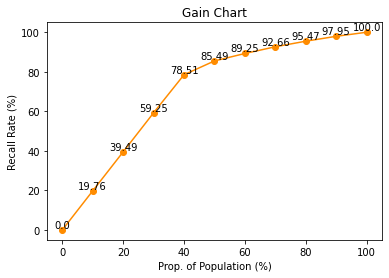

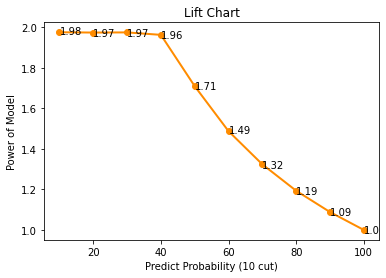

/home/jovyan/work/风险水位/EvalPlot.py:127: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



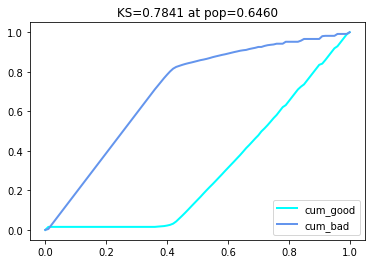

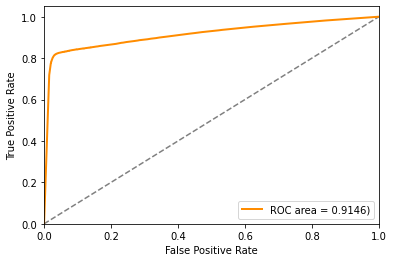

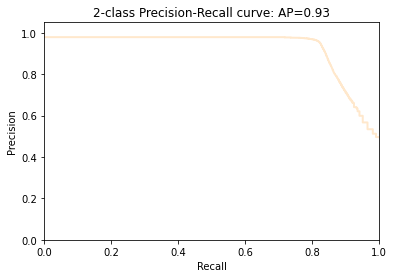

count    52363.000000
mean         0.466032
std          0.226543
min          0.268941
25%          0.268942
50%          0.268967
75%          0.731059
max          0.731059
dtype: float64
    概率  区间cnt    区间cnt%    区间bad%    累积bad%
4  0.7  21982  0.419800  0.962105  0.962105
3  0.6    231  0.004412  0.532468  0.957637
2  0.5    196  0.003743  0.382653  0.952608
1  0.4    262  0.005004  0.320611  0.945305
0  0.3  29692  0.567042  0.151724  0.495312


/home/jovyan/work/风险水位/EvalPlot.py:373: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




Model Report under New Threshold...
Accuracy: 0.8914
Precision:0.9651
Recall:   0.8101
f1-score: 0.8808
ROC_AUC:  0.8907
None


/home/jovyan/work/风险水位/EvalPlot.py:241: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




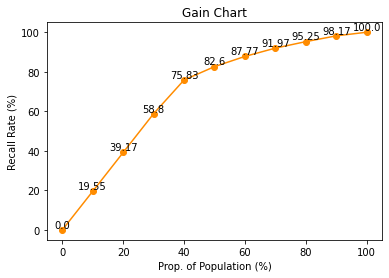

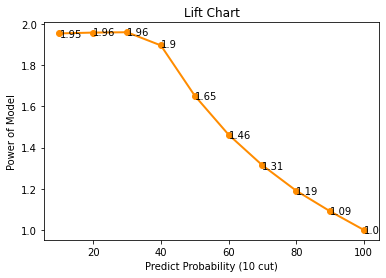

/home/jovyan/work/风险水位/EvalPlot.py:127: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



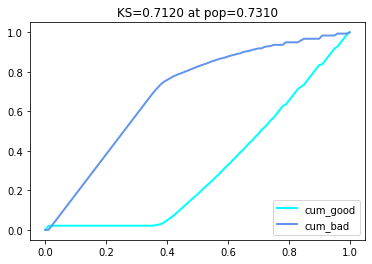

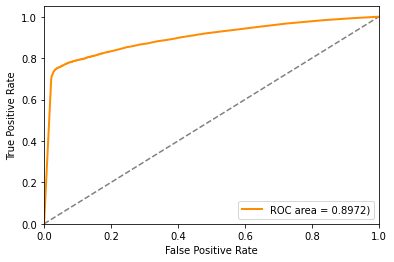

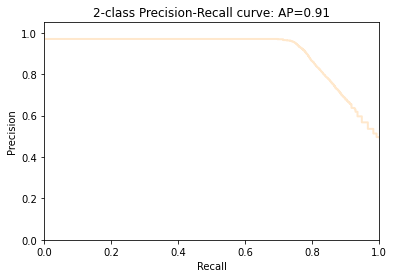

count    22442.000000
mean         0.465190
std          0.225882
min          0.268941
25%          0.268942
50%          0.268975
75%          0.731059
max          0.731059
dtype: float64
    概率  区间cnt    区间cnt%    区间bad%    累积bad%
4  0.7   9341  0.416229  0.919602  0.919602
3  0.6    119  0.005303  0.420168  0.913319
2  0.5    102  0.004545  0.284314  0.906609
1  0.4    164  0.007308  0.359756  0.897388
0  0.3  12716  0.566616  0.187402  0.495098
Model Report under New Threshold...
Accuracy: 0.8546
Precision:0.9249
Recall:   0.7687
f1-score: 0.8396
ROC_AUC:  0.8537
None


/home/jovyan/work/风险水位/EvalPlot.py:373: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




In [16]:
%%local
%matplotlib inline
from EvalPlot import *

# train result 1:1
pred = model.predict([X_indices,T_indices])[:,1]

plotLift(y,pred,n_cut=10)
_ = plotKS(y,pred,n=100,asc=0)
plotROC(y,pred)
plotPR(y,pred)
print(pd.Series(pred).describe())
print(plotDistribute(y.tolist(),pred.tolist()))
print(modelReport(y,pred,0.7))

# test result 1：1
# 把动作转为数值索引
X_test_indices = actions_to_indices(x_test, action_to_index, maxLen)
# 反过来，最后的动作放在最后面
X_test_indices = np.array([i[::-1] for i in X_test_indices])

t_test_scalar = [list(map(time_scalar,i)) for i in t_test]
T_test_indices = np.array([[-1]*(maxLen-len(i))+i[::-1] for i in t_test_scalar])

pred_test = model.predict([X_test_indices,T_test_indices])[:,1]


plotLift(y_test,pred_test,n_cut=10)
_ = plotKS(y_test,pred_test,n=100,asc=0)
plotROC(y_test,pred_test)
plotPR(y_test,pred_test)
print(pd.Series(pred_test).describe())
print(plotDistribute(y_test.tolist(),pred_test.tolist()))
print(modelReport(y_test,pred_test,0.7))

    概率  区间cnt    区间cnt%    区间bad%    累积bad%
4  0.7   8865  0.395018  0.945065  0.945065
3  0.6    102  0.004545  0.500000  0.940002
2  0.5     98  0.004367  0.428571  0.934473
1  0.4    162  0.007219  0.407407  0.925219
0  0.3  13215  0.588851  0.194779  0.495098


Text(0.5, 1.0, 'LSTM')

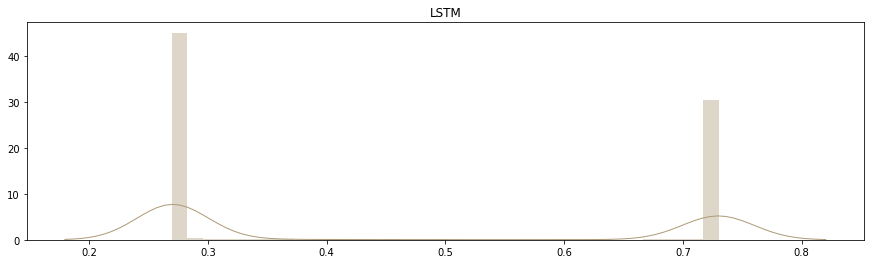

In [309]:
%%local
# plot distribute
print(plotDistribute(y_test.tolist(),pred_test.tolist()))
sns.distplot([round(i,2) for i in pred_test], hist=True, kde=True, 
             bins=int(180/5), 
             color = (174/256,156/256,120/256), 
#              hist_kws={'edgecolor':(164/256,35/256,43/256)},
             kde_kws={'linewidth': 1}).set_title('LSTM')

### 临时把订单属性拼接起来

In [17]:
%%local
# 临时操作
id_cols = ['has_risk','user_id','order_id']
ID = data[id_cols].drop_duplicates()

NameError: name 'data' is not defined

In [101]:
%%local
train_df,test_df = train_test_split(ID, test_size=0.3, random_state=0)
# use lstm prob as feature
train_df['lstm'] = pred
test_df['lstm'] = pred_test
tmp_df = pd.concat([train_df,test_df])

/opt/conda/lib/python3.6/site-packages/sparkmagic/kernels/pysparkkernel/pysparkkernel.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/sparkmagic/kernels/pysparkkernel/pysparkkernel.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [102]:
%%local
id_cols = ['has_risk','ds','user_id','order_id']
ft_cols = ['len_sequence','cnt_pay','max_time_diff','min_time_diff','avg_time_diff','std_time_diff','cnt_src','device_ios','device_android','device_wap','device_web','device_app','device_mini','cnt_login','is_bk_log','is_wzp_log','is_dc_log','cnt_item','cnt_cheap_item','cnt_lyl_item','roi','avg_roi','is_gift_inclued','is_virtual_inclued']
order_df = fetch_df('data_mining','temp_risklevel_feature_order',cols=id_cols+ft_cols)

files in hdfs: /user/holmes/hive_db/data_mining.db/temp_risklevel_feature_order
['000000_0']


In [103]:
%%local
order_df = tmp_df.merge(order_df)
ft_cols.append('lstm')

### GBDT STACKING

In [104]:
%%local
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
from EvalPlot import *

target = 'has_risk'
order_df[ft_cols] = order_df[ft_cols].astype(float)
order_df[target] = order_df[target].astype(int)

train_x, test_x, train_y, test_y = train_test_split(
    order_df[ft_cols],order_df[target],test_size=0.3, random_state=0)

In [105]:
%%local
def batch_model_result(label,pred,name='数据集',t=0.7):
    print(name,end=':')
    print(type(label),type(pred))
    plotLift(label,pred,n_cut=10)
    _ = plotKS(label,pred,n=100,asc=0)
    plotROC(label,pred)
    plotPR(label,pred)
    print(pd.Series(pred).describe())
    print(plotDistribute(label.tolist(),pred.tolist()))
    print(modelReport(label,pred,t))
    return 

In [177]:
%%local
# training GBDT
GBDT_model = GradientBoostingClassifier(
 learning_rate =0.1,
 n_estimators=100,
 subsample=0.6,
 max_depth=3,
 max_features=0.64,
 min_samples_leaf=0.05,
 criterion='friedman_mse',
 verbose=1,
 random_state=100)
GBDT_model.fit(train_x,train_y)

# model evaluation
train_prob = GBDT_model.predict_proba(train_x)[:,1] #抽样训练集
test_prob = GBDT_model.predict_proba(test_x)[:,1] #抽样测试集

tmp = pd.DataFrame(columns=['抽样训练集','抽样测试集'],
    index=['size','bad','auc','ks'],
    data=[
    [len(train_x),len(test_x)],
    [sum(train_y),sum(test_y)],
    [auc_train,  auc_test],
    [ks_train, ks_test]
    ])
tmp.loc['size'] = tmp.loc['size'].map(lambda x:format(int(x),',d'))
tmp.loc['bad'] = tmp.loc['bad'].map(lambda x:format(int(x),',d'))
tmp.loc['auc'] = tmp.loc['auc'].map('{:,.4f}'.format)
tmp.loc['ks'] = tmp.loc['ks'].map('{:,.4f}'.format)
print(tmp)


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2708           0.1147            6.00s
         2           1.1760           0.0932            6.73s
         3           1.0981           0.0771            6.81s
         4           1.0329           0.0645            6.91s
         5           0.9896           0.0454            6.60s
         6           0.9436           0.0478            6.61s
         7           0.9019           0.0393            6.38s
         8           0.8667           0.0333            6.22s
         9           0.8410           0.0286            6.06s
        10           0.8177           0.0243            6.01s
        20           0.6873           0.0049            5.21s
        30           0.6524           0.0021            4.46s
        40           0.6480           0.0007            3.82s
        50           0.6412           0.0002            3.17s
        60           0.6414           0.0001            2.55s
       

In [222]:
%%local
import pickle
pickle.dump(GBDT_model,open(os.path.join(cur_dir,'model','gbdt'),'wb'))

训练集:<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


/home/jovyan/work/风险水位/EvalPlot.py:241: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




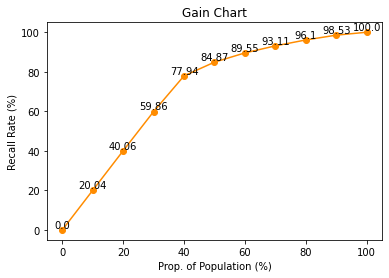

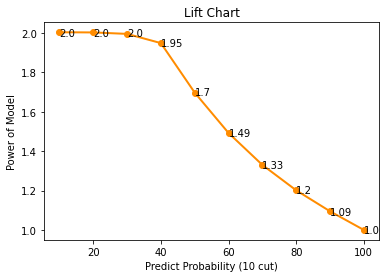

/home/jovyan/work/风险水位/EvalPlot.py:127: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



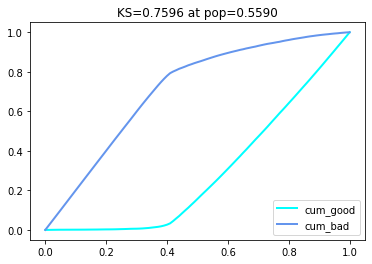

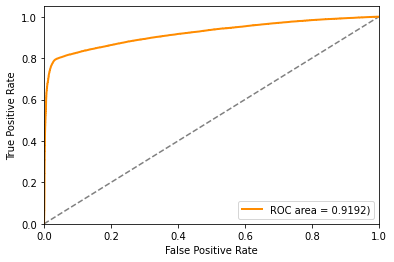

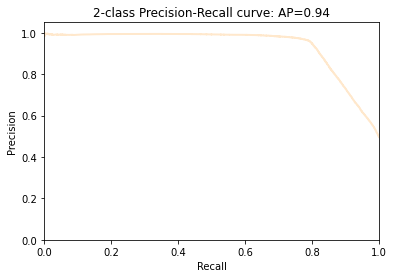

count    52363.000000
mean         0.495946
std          0.392500
min          0.053245
25%          0.148777
50%          0.238506
75%          0.974589
max          0.993471
dtype: float64
    概率  区间cnt    区间cnt%    区间bad%    累积bad%
9  1.0  17404  0.332372  0.986497  0.986497
8  0.9   2908  0.055535  0.893054  0.973119
7  0.8    720  0.013750  0.752778  0.965576
6  0.7    282  0.005385  0.677305  0.961762
5  0.6    178  0.003399  0.561798  0.958450
4  0.5    277  0.005290  0.444043  0.951904
3  0.4    648  0.012375  0.356481  0.934692
2  0.3   2938  0.056108  0.297822  0.860895
1  0.2  13687  0.261387  0.198656  0.628733
0  0.1  13321  0.254397  0.107049  0.496018
Model Report under New Threshold...
Accuracy: 0.8274
Precision:0.9865
Recall:   0.6610
f1-score: 0.7916
ROC_AUC:  0.8261
None
测试集:<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


/home/jovyan/work/风险水位/EvalPlot.py:373: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)


/home/jovyan/work/风险水位/EvalPlot.py:241: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




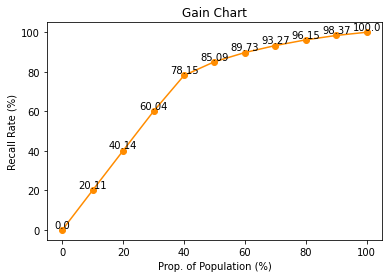

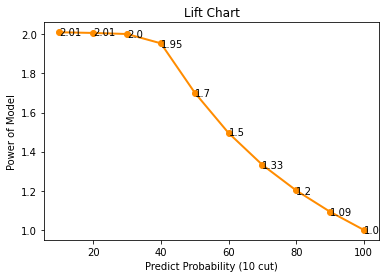

/home/jovyan/work/风险水位/EvalPlot.py:127: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



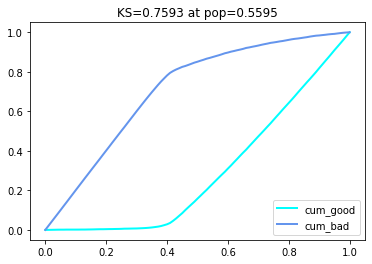

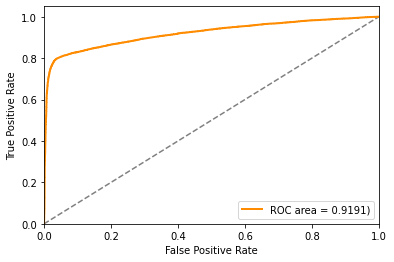

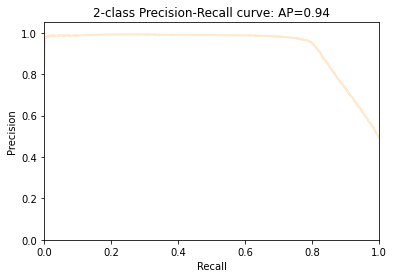

count    22442.000000
mean         0.495603
std          0.392310
min          0.052901
25%          0.148974
50%          0.236316
75%          0.974473
max          0.993706
dtype: float64
    概率  区间cnt    区间cnt%    区间bad%    累积bad%
9  1.0   7480  0.333304  0.984492  0.984492
8  0.9   1186  0.052847  0.890388  0.971613
7  0.8    323  0.014393  0.746130  0.963511
6  0.7    140  0.006238  0.685714  0.959251
5  0.6     84  0.003743  0.607143  0.956040
4  0.5    130  0.005793  0.453846  0.949053
3  0.4    286  0.012744  0.388112  0.932392
2  0.3   1182  0.052669  0.292724  0.862455
1  0.2   5934  0.264415  0.196663  0.626515
0  0.1   5697  0.253854  0.102335  0.493450
Model Report under New Threshold...
Accuracy: 0.8295
Precision:0.9845
Recall:   0.6650
f1-score: 0.7938
ROC_AUC:  0.8274
None


/home/jovyan/work/风险水位/EvalPlot.py:373: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




In [178]:
%%local
batch_model_result(train_y,train_prob,name='训练集',t=0.95)
batch_model_result(test_y,test_prob,name='测试集',t=0.95)

训练集:<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


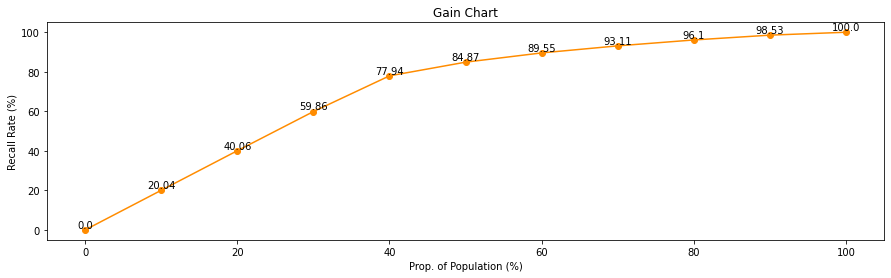

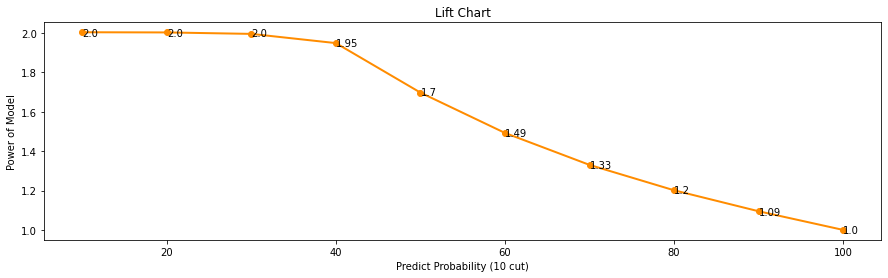

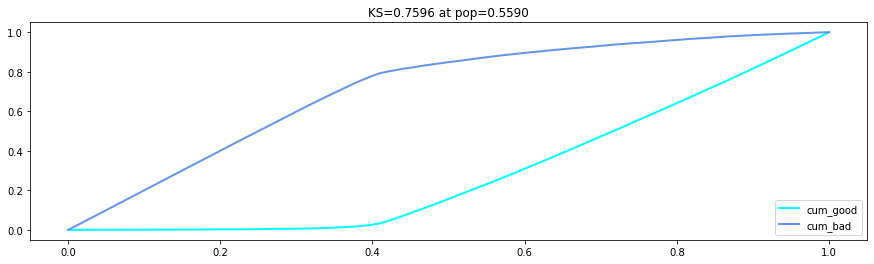

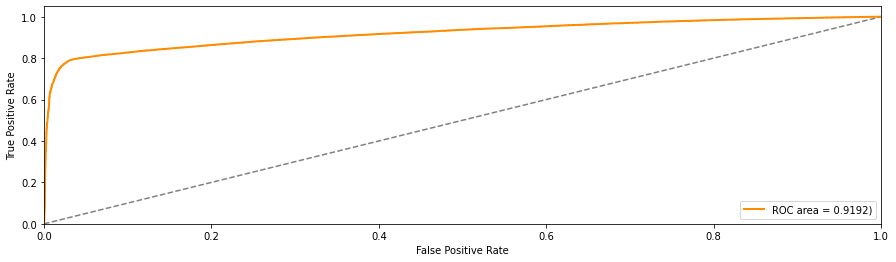

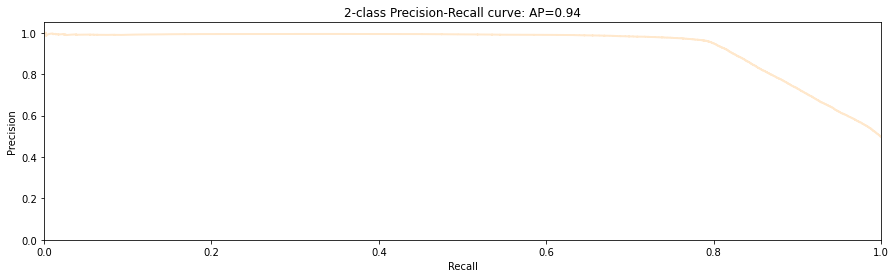

count    52363.000000
mean         0.495946
std          0.392500
min          0.053245
25%          0.148777
50%          0.238506
75%          0.974589
max          0.993471
dtype: float64
    概率  区间cnt    区间cnt%    区间bad%    累积bad%
9  1.0  17404  0.332372  0.986497  0.986497
8  0.9   2908  0.055535  0.893054  0.973119
7  0.8    720  0.013750  0.752778  0.965576
6  0.7    282  0.005385  0.677305  0.961762
5  0.6    178  0.003399  0.561798  0.958450
4  0.5    277  0.005290  0.444043  0.951904
3  0.4    648  0.012375  0.356481  0.934692
2  0.3   2938  0.056108  0.297822  0.860895
1  0.2  13687  0.261387  0.198656  0.628733
0  0.1  13321  0.254397  0.107049  0.496018
Model Report under New Threshold...
Accuracy: 0.7751
Precision:0.9902
Recall:   0.5521
f1-score: 0.7089
ROC_AUC:  0.7733
None
测试集:<class 'pandas.core.series.Series'> <class 'numpy.ndarray'>


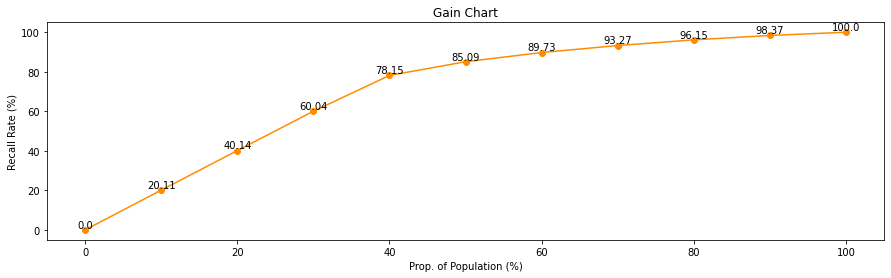

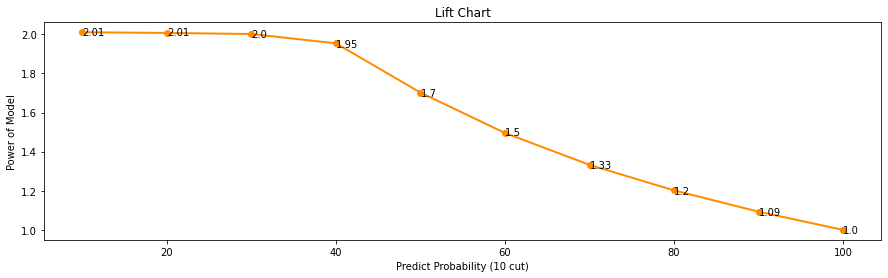

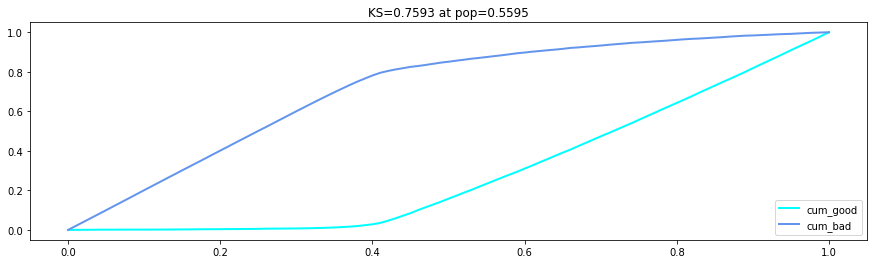

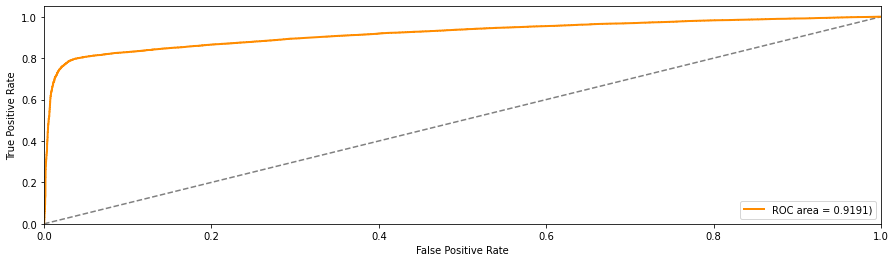

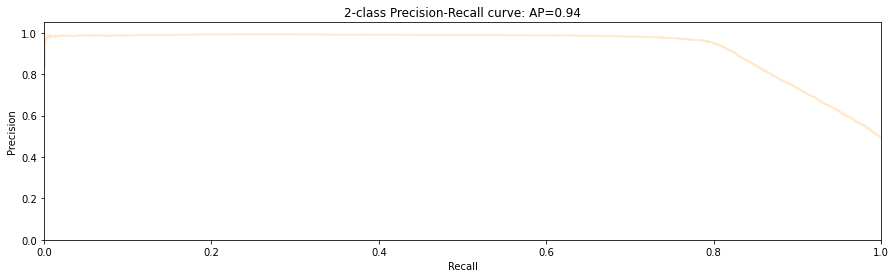

count    22442.000000
mean         0.495603
std          0.392310
min          0.052901
25%          0.148974
50%          0.236316
75%          0.974473
max          0.993706
dtype: float64
    概率  区间cnt    区间cnt%    区间bad%    累积bad%
9  1.0   7480  0.333304  0.984492  0.984492
8  0.9   1186  0.052847  0.890388  0.971613
7  0.8    323  0.014393  0.746130  0.963511
6  0.7    140  0.006238  0.685714  0.959251
5  0.6     84  0.003743  0.607143  0.956040
4  0.5    130  0.005793  0.453846  0.949053
3  0.4    286  0.012744  0.388112  0.932392
2  0.3   1182  0.052669  0.292724  0.862455
1  0.2   5934  0.264415  0.196663  0.626515
0  0.1   5697  0.253854  0.102335  0.493450
Model Report under New Threshold...
Accuracy: 0.7762
Precision:0.9877
Recall:   0.5534
f1-score: 0.7093
ROC_AUC:  0.7733
None


In [312]:
%%local
batch_model_result(train_y,train_prob,name='训练集',t=0.97)
batch_model_result(test_y,test_prob,name='测试集',t=0.97)

Text(0.5, 1.0, 'GBDT')

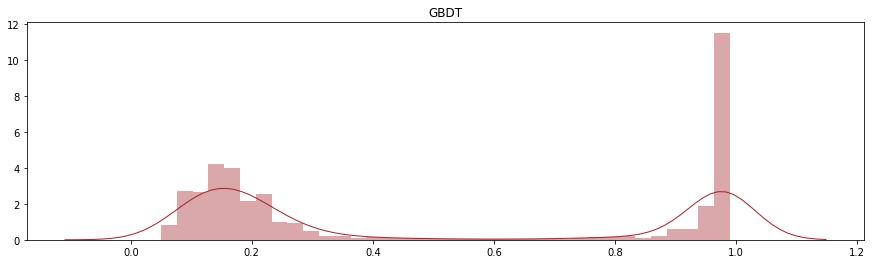

In [308]:
%%local
sns.distplot([round(i,2) for i in test_prob], hist=True, kde=True, 
             bins=int(180/5), 
             color = (164/256,35/256,43/256), 
             kde_kws={'linewidth': 1}).set_title('GBDT')

### 跨时区验证（还原真实比例）

In [10]:
%%local
##跨时区模型验证
cols = ['ds','has_risk','user_id','order_id','src','client_type','event_action','page_name','log_time','time_diff','rk']
oot = fetch_df('data_mining','rc_risklevel_oot1_feature',cols=cols,sep=',')
oot = oot.replace(r'\\N',  ' ', regex=True)
oot = oot.astype(str)
oot['action_page'] = oot['event_action'].str.cat(oot['page_name'],sep='_')
oot['action_page'] = oot['action_page'].str.lstrip(' _')
oot['rk'] = oot['rk'].astype(int)
oot['delta_time'] = oot.time_diff.astype(int).diff().shift(-1)
idx = oot['rk'] == oot.groupby('order_id')['rk'].transform(max)
oot['delta_time'][idx] = 0

files in hdfs: /user/holmes/hive_db/data_mining.db/rc_risklevel_oot1_feature
['000000_0']


/opt/conda/lib/python3.6/site-packages/sparkmagic/kernels/pysparkkernel/pysparkkernel.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [155]:
%%local
# oot.to_csv('oot1.csv',index=False)

In [74]:
%%local
# # 临时检查，1：1抽样跨时区
# id_df = oot[['ds','has_risk','user_id','order_id']].drop_duplicates()
# pos = id_df[id_df.has_risk=='1']
# print(pos.shape)
# neg = id_df[id_df.has_risk=='0'].sample(len(pos),random_state=0)
# print(neg.shape)
# id_ls = pos.order_id.values.tolist()+neg.order_id.values.tolist()
# oot_tmp = oot[oot.order_id.isin(id_ls)]

(3501, 4)
(3501, 4)


In [11]:
%%local
order_id = ''
X_oot,x_oot,Y_oot = [],[],[]
T_oot,t_oot = [],[]
for idx, row in oot.iterrows():
    if row.order_id != order_id or idx==len(oot)-1:
        if order_id!='':
            X_oot.append(x_oot)
            Y_oot.append(y)
            T_oot.append(t_oot)
        # 重新初始化
        user_id = row.user_id
        order_id = row.order_id
        y = row.has_risk
        x_oot = []
        t_oot = []

    x_oot.append(row.action_page)
    t_oot.append(row.delta_time)

In [12]:
%%local
len(X_oot),len(Y_oot),len(T_oot),sum(map(int,Y_oot))

(284193, 284193, 284193, 19676)

In [14]:
%%local
oot.ds.unique()

array(['2020-07-01', '2020-07-02', '2020-07-03', '2020-07-04',
       '2020-07-05', '2020-07-06', '2020-07-07', '2020-07-08',
       '2020-07-09', '2020-07-10', '2020-07-11', '2020-07-12',
       '2020-07-13', '2020-07-14', '2020-07-15', '2020-07-16',
       '2020-07-17', '2020-07-18', '2020-07-19', '2020-07-20',
       '2020-07-21', '2020-07-22', '2020-07-23', '2020-07-24',
       '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28',
       '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01',
       '2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
       '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
       '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
       '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
       '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
       '2020-08-22', '2020-08-23', '2020-08-24', '2020-08-25'],
      dtype=object)

In [15]:
%%local
X_oot = np.asarray(X_oot)
T_oot = np.asarray(T_oot)
Y_oot = np.asarray(Y_oot).astype('int64')

In [18]:
%%local
maxLen = len(max(X_oot, key=len))

# 读取单个动作的 embedding，作数值索引
action_to_index, index_to_action, action_to_vec_map = read_action_vecs(emb_dir)

X_oot_indices = actions_to_indices(X_oot, action_to_index, maxLen,ref='exit_sizehelperedit')
X_oot_indices = np.array([i[::-1] for i in X_oot_indices])

t_scalar_oot = [list(map(time_scalar,i)) for i in T_oot]
T_oot_indices = np.array([[-1]*(maxLen-len(i))+i[::-1] for i in t_scalar_oot])


click_supermc_index False
click_supermc_index False
receive_push_sizehelpercompare False
view_app False
view_selfdownload False
click_supermc_index False
click_supermc_index False
view_membershipgrowth False
scan_default False
open_aboutus False
click_cate1005000 False
click_cate1005000 False
add_pointsdetail False
add_pointsdetail False
add_pointsdetail False
add_pointsdetail False
open_aboutus False
receive_push_sizehelperedit False
view_app False
open_aboutus False
open_aboutus False
receive_push_msgcenter False
view_scratchcard False
click_orderpickgift False
view_membershipgrowth False
share_plusmember False
share_plusmember False
login_mypage False
view_scratchcard False
view_scratchcard False
exit_delivery False
open_delivery False
view_scratchcard False
view_scratchcard False
view_scratchcard False
click_scratchcard False
view_scratchcard False
view_scratchcard False
click_scratchcard False
click_scratchcard False
view_scratchcard False
exit_accassociate False
exit_accassociate

view_saleRank False
view_saleRank False
view_TemplateMsg False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_praiseRank False
view_praiseRank False
view_praiseRank False
view_praiseRank False
view_praiseRank False
view_saleRank False
starredirect False
starorder False
view_saleRank False
view_saleRank False
view_saleRank False
view_membershipgrowth False
add_footprint False
add_footprint False
add_footprint False
click_orderpickgift False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank False
view_saleRank Fals

click_moneycalculator False
click_orderpickgift False
click_orderpickgift False
login_+ False
click_moneycalculator False
view_CommunityBind False
view_CommunityBind False
view_CommunityBind False
receive_push_membership False
login_+ False
login_+ False
click_CommunityBind False
view_CommunityBind False
view_CommunityBind False
click_CommunityBind False
view_CommunityBind False
click_cate1005002 False
click_cate1005002 False
view_CommunityBind False
view_CommunityBind False
click_CommunityBind False
view_CommunityBind False
login_+ False
view_CommunityBind False
view_CommunityBind False
view_CommunityBind False
view_CommunityBind False
view_CommunityBind False
view_CommunityBind False
view_CommunityBind False
click_CommunityBind False
view_CommunityBind False
click_msg False
click_msg False
view_CommunityBind False
view_CommunityBind False
view_CommunityBind False
view_CommunityBind False
click_CommunityBind False
view_CommunityBind False
view_CommunityBind False
view_CommunityBind Fa

click_ feedbackmoney False
click_ feedbackmoney False
click_ feedbackmoney False
click_ feedbackmoney False
click_ feedbackmoney False
click_ feedbackmoney False
click_ feedbackmoney False
click_ feedbackmoney False
click_ feedbackmoney False
click_ feedbackmoney False
login_+ False
view_CommunityBind False
view_CommunityBind False
click_ feedbackmoney False
click_ feedbackmoney False
login_+ False
click_ feedbackmoney False
view_CommunityBind False
click_CommunityBind False
view_CommunityBind False
view_CommunityBind False
click_CommunityBind False
view_CommunityBind False
login_+ False
login_+ False
login_+ False
login_+ False
login_+ False
login_+ False
login_+ False
login_+ False
login_orderconfirm False
login_+ False
click_ feedbackmoney False
login_+ False
click_priceprotect False
click_ feedbackmoney False
login_+ False
click_CommunityBind False
view_CommunityBind False
click_CommunityBind False
click_CommunityBind False
view_CommunityBind False
click_CommunityBind False
login_+

NameError: name 'model' is not defined

In [42]:
%%local
output.head()

Output()

In [20]:
%%local
model = load_model(model_dir)
# model = load_model(model_dir)
oot_pred = model.predict([X_oot_indices,T_oot_indices])[:,1]

batch_model_result(Y_oot,oot_pred,name='跨时区验证集',t=0.7)

OSError: Unable to open file (file read failed: time = Wed Sep  9 17:02:53 2020
, filename = '/home/jovyan/model/lstm_a99_t4_ft20_e50', file descriptor = 73, errno = 21, error message = 'Is a directory', buf = 0x7ffed1ac1170, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

In [19]:
%%local
sum(Y_oot)

19676

In [161]:
%%local
tmp = oot[['user_id']].drop_duplicates()
tmp['lstm'] = oot_pred

In [162]:
%%local
# ft_cols = ['len_sequence','cnt_pay','max_time_diff','min_time_diff','avg_time_diff','std_time_diff','cnt_src','device_ios','device_android','device_wap','device_web','device_app','device_mini','cnt_login','is_bk_log','is_wzp_log','is_dc_log','cnt_item','cnt_cheap_item','cnt_lyl_item','roi','avg_roi','is_gift_inclued','is_virtual_inclued']
# oot = fetch_df('data_mining','temp_risklevel_oot_feature_order',cols=id_cols+ft_cols)
# oot.to_csv('oot1_order.csv',index=False)
oot = pd.read_csv('oot1_order.csv')
ft_cols.append('lstm')

In [166]:
%%local
oot['user_id'] = oot['user_id'].astype(str)
oot = oot.merge(tmp)
oot[ft_cols] = oot[ft_cols].astype(float)
oot[target] = oot[target].astype(int)

In [179]:
%%local
oot_prob = GBDT_model.predict_proba(oot[ft_cols])[:,1] #抽样测试集

GBDT跨时区验证集:<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/home/jovyan/work/风险水位/EvalPlot.py:241: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




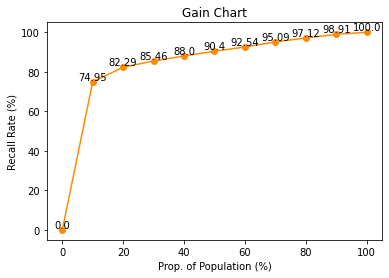

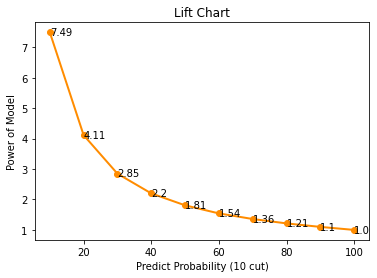

/home/jovyan/work/风险水位/EvalPlot.py:127: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



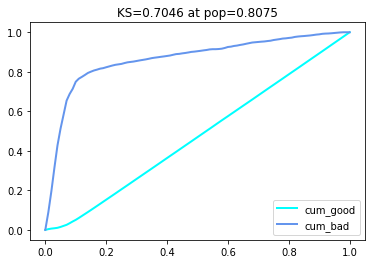

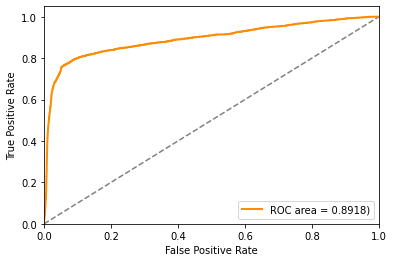

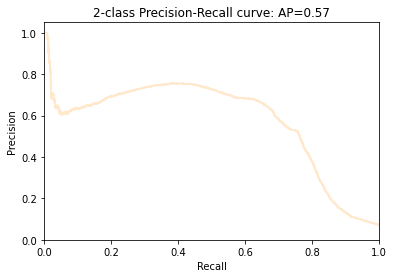

count    49669.000000
mean         0.259837
std          0.265799
min          0.052204
25%          0.113010
50%          0.157014
75%          0.235972
max          0.993590
dtype: float64
    概率  区间cnt    区间cnt%    区间bad%    累积bad%
9  1.0   3475  0.069963  0.658993  0.658993
8  0.9   1701  0.034247  0.216931  0.513717
7  0.8    765  0.015402  0.066667  0.456152
6  0.7    384  0.007731  0.062500  0.432253
5  0.6    198  0.003986  0.080808  0.421585
4  0.5    408  0.008214  0.068627  0.400808
3  0.4    841  0.016932  0.047562  0.362584
2  0.3   3543  0.071332  0.029071  0.258153
1  0.2  15260  0.307234  0.017759  0.120113
0  0.1  23094  0.464958  0.013380  0.070487
Model Report under New Threshold...
Accuracy: 0.9518
Precision:0.7109
Recall:   0.5338
f1-score: 0.6098
ROC_AUC:  0.7587
None


/home/jovyan/work/风险水位/EvalPlot.py:373: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)




In [183]:
%%local
batch_model_result(oot[target].values,oot_prob,name='GBDT跨时区验证集',t=0.97)

In [352]:
%%local
modelReport(oot[target].values,oot_prob,0.95)

Model Report under New Threshold...
Accuracy: 0.9518
Precision:0.6590
Recall:   0.6541
f1-score: 0.6565
ROC_AUC:  0.8142


In [189]:
%%local
tmp = [round(i*100,0) for i in oot_prob if i>0.9]
pd.Series(tmp).value_counts()

98.0    1298
99.0     887
97.0     734
96.0     392
95.0     320
93.0     245
94.0     241
91.0     212
92.0     188
90.0     120
dtype: int64

In [351]:
%%local
print(sum(oot_prob>=0.95))
print(modelReport(oot[target].values,oot_prob,0.95))

3475
Model Report under New Threshold...
Accuracy: 0.9518
Precision:0.6590
Recall:   0.6541
f1-score: 0.6565
ROC_AUC:  0.8142
None


### 查看错分

In [192]:
%%local
# LSTM
check = oot[['has_risk','ds','user_id','order_id','lstm']]
check['gbdt'] = oot_prob
check.head()

/opt/conda/lib/python3.6/site-packages/sparkmagic/kernels/pysparkkernel/pysparkkernel.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

In [353]:
%%local
fp = check[(check.has_risk==0)&(check.gbdt>=0.95)]
len(fp)

1185

In [316]:
%%local
# 回写数据库
fp[['has_risk','ds','user_id','order_id','lstm','gbdt']].to_csv('fp.csv',index=False,header=False)
fn[['has_risk','ds','user_id','order_id','lstm','gbdt']].to_csv('fn.csv',index=False,header=False)

# hive
# create table data_mining.rc_risklevel_result (
#     has_risk int, 
#     ds string, 
#     user_id string, 
#     order_id string, 
#     lstm float, 
#     gbdt float) 
# row format delimited fields terminated by ',';

# load data local inpath '/home/jovyan/work/风险水位/fp.csv'
# overwrite
# into table data_mining.rc_risklevel_result;

# load data local inpath '/home/jovyan/work/风险水位/fn.csv'
# into table data_mining.rc_risklevel_result;

In [194]:
%%local
fp.sample(20,random_state=0)
# wrong 26219240620 首单礼品卡支付

Output()